In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import random


#### STEP 1 - INITIALIZE DATA
def getName(filePath):
    myImagePathL = filePath.split('/')[-2:]
    myImagePath = os.path.join(myImagePathL[0],myImagePathL[1])
    return myImagePath

def importDataInfo(path):
    columns = ['Center','Steering']
    noOfFolders = len(os.listdir(path))//2
    data = pd.DataFrame()
    dataNew = pd.read_csv(os.path.join(path, f'log_{0}.csv'), names = columns)
    print(f'{0}:{dataNew.shape[0]} ',end='')
    dataNew['Center']=dataNew['Center'].apply(getName)
    data =data.append(dataNew,True )
    print(' ')
    print('Total Images Imported',data.shape[0])
    return data

#### STEP 2 - VISUALIZE AND BALANCE DATA
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin =  300
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Data Visualisation')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Balanced Data')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    return data

#### STEP 3 - PREPARE FOR PROCESSING
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append( os.path.join(path,indexed_data[0]))
    steering.append(float(indexed_data[1]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering


#### STEP 4 - AUGMENT DATA
def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.5, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

#### STEP 5 - PREPROCESS
def preProcess(img):
    img = img[54:120,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

#### STEP 6 - CREATE MODEL (like tiny VGG)
def createModel():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                          kernel_size = 3,
                          activation = "relu",
                          input_shape = (512, 512, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                             padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2)])

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  model.compile(Adam(lr=0.00001),loss='mse')
  return model

#### STEP 7 - TRAINNING
def dataGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))



Setting UP
0:156  
Total Images Imported 156


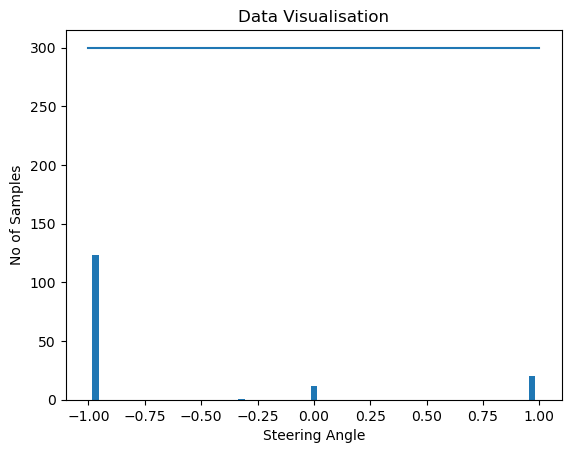

Removed Images: 0
Remaining Images: 156


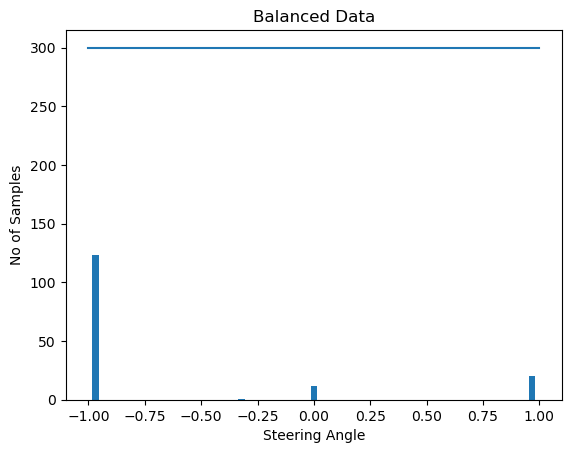

Total Training Images:  124
Total Validation Images:  32


c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ALI\AppData\Local\Temp\ipykernel_15412\2559855313.py", line 40, in <module>
      validation_steps=50)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\ali\desktop\projects\prj3\prj3\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 611000 values, but the requested shape requires a multiple of 156250
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_train_function_1137]

In [7]:
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
#from utlis import *
import cv2
import glob
#### STEP 1 - INITIALIZE DATA
path = 'DataCollected'
data= importDataInfo(path);

#### STEP 2 - VISUALIZE AND BALANCE DATA
data = balanceData(data,display=True);

#### STEP 3 - PREPARE FOR PROCESSING
imagesPath, steerings = loadData(path,data);

cv2.imshow('Test Image',cv2.imread(imagesPath[5]))

cv_img = []
for img in glob.glob(r"C:\Users\ALI\Desktop\projects\prj3\DataCollected\IMG0\*.jpg"):
    n= cv2.imread(img);
    cv_img.append(n);


#### STEP 4 - SPLIT FOR TRAINING AND VALIDATION
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings,test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))


#### STEP 7 - CREATE MODEL
model = createModel()

#### STEP 8 - TRAINNING
history = model.fit(dataGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=50,
                                  epochs=10,
                                  validation_data=dataGen(xVal, yVal, 50, 0),
                                  validation_steps=50)

#### STEP 9 - SAVE THE MODEL
model.save('model.h5')
print('Model Saved')

#### STEP 10 - PLOT THE RESULTS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()